# Model Building and Optimization 

This notebook is a follow-up to the <code> 01_EDA </code> exploration. Our goal will be to find a model that best predicts medical appointment no-shows using the Aquarela Advanced Analytics dataset. 

In [359]:
# Import all packages

import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

## The Goal

In this exploration we will look at a few models that are well-suited to binary classification problems to optimize our prediction of medical appointment no-shows. 

We established that our dataset has a class imbalance (20% positive cases - no-shows vs. 80% negative cases) which means that we need to think carefully about how to measure the success of our models. We'll consider overall performance by looking at ROC curves. However, given that our ultimate goal is to reduce no-shows, we want to focus on optimizing <u>recall</u> more so than precision. After all, if we classify a few people who are going to show up to their appointments as no-showers (the false positives), they might receive an extra text or call, but ultimately still be unaffected. That said, if we have a high false negative rate, we'll be missing opportunities to intervene in appointments that would otherwise be missed. 

The models under consideration are as follow:

* Logistic Regression – Baseline for the model
* K-Nearest Neighbours - ffective when the number of samples is large (in this case, 110k), and interesting to experiment with because of the number of parameters that can be tuned
* Random Forest – With the sparsity of the data, the sub-sampling could be effective and might control for overfitting

We will start by dividing the data into training and test sets. We will then tackle the class imbalance through a combination of SMOTE and undersampling. Once this is complete, the training set will once again be split to provide a training and validation set. 

Once we've gauged the performance of the standard models, we will choose one to optimize. We will consider the most suitable hyperparameters through a combination of using validation curves and GridSearchCV, comparing the results of both methods. 

We will evaluate our model against the test set and calculate the confusion matrix for the results. Finally, we will wrap up by talking about feature importance for the model. 

In [360]:
# Import our data

df = pd.read_csv('cleaned_data.csv', index_col=0)

# Choose relevant features for model-building - see 01_EDA for methodology behind feature selection 

df_model = df[['No-show','Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Sched_to_App_Time', 'Num_NS']]

Now that we have a subset of the data that we will use for model-building, let's split our dateframe into a train and test set. We will later split it again into train and validation sets, but first we need to deal with the class imbalance. Ultimately, we'll have the following splits:

* <b> Train: </b> 60% (~66,000 samples)
* <b> Validation: </b> 20% (~22,000 samples)
* <b> Test: </b> 20% (~22,000 samples)
<br>

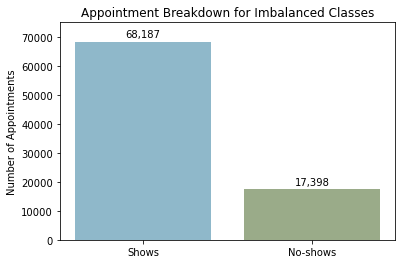

In [361]:
# Define target and features

X = df_model.drop('No-show', axis=1)
y = df_model['No-show'].values

# Set a random state & scale the data

r_state = 42 
X = StandardScaler().fit_transform(X)

# Train/test split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = r_state)

# Plot our training set to see the imbalance between classes

counter = Counter(y_train)

fig = plt.figure()
ax = plt.bar(counter.keys(), counter.values(), color=['#9AAB89', '#8FB8CA'])
plt.xticks(ticks=[0,1], labels=['Shows','No-shows'])
plt.ylim([0,75000])
plt.text(0, 70000, s='68,187',horizontalalignment='center')
plt.text(1, 19000, s='17,398',horizontalalignment='center')
plt.ylabel('Number of Appointments')
plt.title('Appointment Breakdown for Imbalanced Classes')

fig.savefig("images/imbalanced_class.png")
plt.show()

With the barplot we can see the class imbalance we currently have on our modelling data. We will balance the classes by first using SMOTE to oversample the minority class and then using random undersampling to reduce the number of examples for the majority class.

In SMOTE, a random example from the minority class chosen, and k of the nearest neighbors for that example are found. A nieghbour is randomly selected and a synthetic example is created at a randomly selected point between the two examples in feature space.

In [362]:
# Print counter of imbalanced classes so we can compare our class shift later on

print(counter)

# Define pipeline

over = SMOTE(sampling_strategy = 0.4, random_state = r_state)
under = RandomUnderSampler(sampling_strategy= 0.5, random_state = r_state)
pipeline = Pipeline(steps=[('o', over), ('u', under)])

# Transform the dataset

X_train, y_train = pipeline.fit_resample(X_train, y_train)

# Summarize the new class distribution

counter = Counter(y_train)
print(counter)

Counter({0: 68187, 1: 17398})
Counter({0: 54548, 1: 27274})


Great, let's now plot how our new rebalanced dataset looks. 

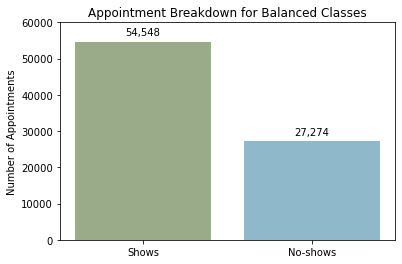

In [363]:
fig = plt.figure()
ax = plt.bar(counter.keys(), counter.values(), color=['#9AAB89', '#8FB8CA'])
plt.xticks(ticks=[0,1], labels=['Shows','No-shows'])
plt.ylim([0,60000])
plt.text(0, 56500, s='54,548',horizontalalignment='center')
plt.text(1, 29000, s='27,274',horizontalalignment='center')
plt.ylabel('Number of Appointments')
plt.title('Appointment Breakdown for Balanced Classes')

fig.savefig("images/balanced_class.png")
plt.show()

Our ratio used of no-shows to shows used to be 1:4 and now we're closer to 1:2. Now that we've rebalanced our classes, we can split our training set again so that we have a training and validation set to use for our model exploration.

In [364]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = r_state)

Now let's fit the four models we're considering onto our training data, comparing their performance with ROC and precision-recall curves.

No Skill: ROC AUC=0.500
Logistic Regression: ROC AUC=0.902
KNN Classifier: ROC AUC=0.921
Random Forest Classifier: ROC AUC=0.935


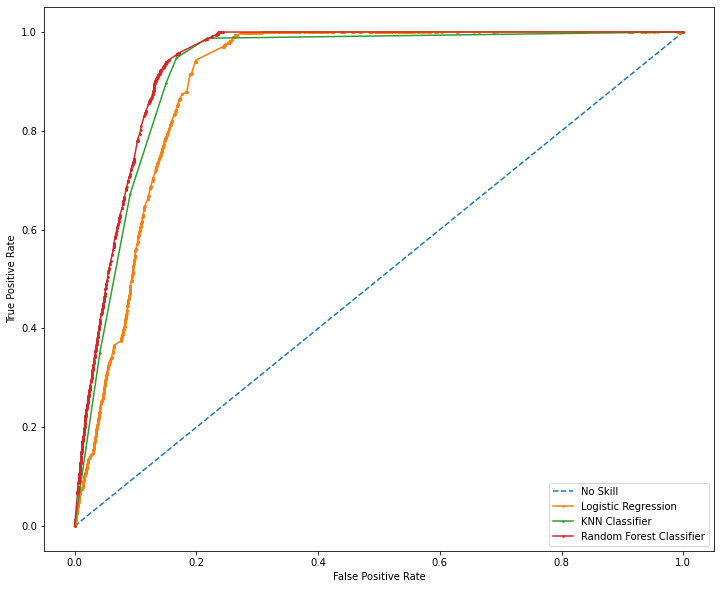

In [365]:
# Generate a no skill prediction (majority class)

ns_prob = [0 for _ in range(len(y_val))]

# Get prediction probability and predicted label for a classifier 

def get_prob_pred(classifier, X_train, y_train, X_val):
    classifier.fit(X_train, y_train)
    cl_prob = classifier.predict_proba(X_val)
    cl_prob = cl_prob[:,1]
    cl_y_pred = classifier.predict(X_val)
    return cl_prob, cl_y_pred
    
lr_prob, lr_pred = get_prob_pred(LogisticRegression(), X_train, y_train, X_val)  
knn_prob, knn_pred = get_prob_pred(KNeighborsClassifier(), X_train, y_train, X_val)    
rf_prob, rf_pred = get_prob_pred(RandomForestClassifier(), X_train, y_train, X_val)    


# Calculate scores

ns_auc = roc_auc_score(y_val, ns_prob)
lr_auc = roc_auc_score(y_val, lr_prob)
knn_auc = roc_auc_score(y_val, knn_prob)
rf_auc = roc_auc_score(y_val, rf_prob)

#Summarize scores

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))
print('KNN Classifier: ROC AUC=%.3f' % (knn_auc))
print('Random Forest Classifier: ROC AUC=%.3f' % (rf_auc))

# Calculate ROC curves

ns_fpr, ns_tpr, threshold = roc_curve(y_val, ns_prob)
lr_fpr, lr_tpr, threshold = roc_curve(y_val, lr_prob)
knn_fpr, knn_tpr, threshold = roc_curve(y_val, knn_prob)
rf_fpr, rf_tpr, threshold = roc_curve(y_val, rf_prob)

# Plot the ROC curve for the model
fig = plt.figure(figsize=[12,10])

plt.plot(cmap=plt.cm.YlGn)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', markersize=3,label='Logistic Regression')
plt.plot(knn_fpr, knn_tpr, marker='.',markersize=3, label='KNN Classifier')
plt.plot(rf_fpr, rf_tpr, marker='.', markersize=3,label='Random Forest Classifier')


# Axis labels

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Show the legend

plt.legend()

# Show the plot

fig.savefig("images/ROC_AUC.png")
plt.show()

From the ROC AUC score, it looks like the Random Forest Classifier is our most promising model to tune given its score of 0.935. However, before we confirm this, we need to have a look at the precision-recall curves. Remember, we are going to lean in the direction of models that have better recall, since we are willing to have more false negatives in favour of being able to capture more true positives (and as a result, we're willing to let in more false positives into our model. 

Logistic Regression: recall=0.619 auc=0.731
KNN Classifier: recall=0.816 auc=0.818
Random Forest Classifier: recall=0.834 auc=0.823


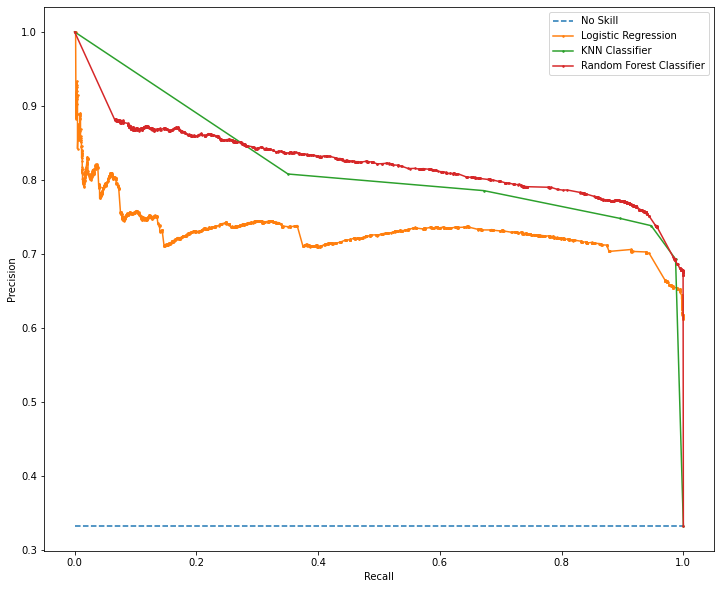

In [366]:
# Predict precision and recall

lr_precision, lr_recall, threshold = precision_recall_curve(y_val, lr_prob)
lr_f1, lr_auc = f1_score(y_val, lr_pred), auc(lr_recall, lr_precision)

knn_precision, knn_recall, threshold = precision_recall_curve(y_val, knn_prob)
knn_f1, knn_auc = f1_score(y_val, knn_pred), auc(knn_recall, knn_precision)

rf_precision, rf_recall, threshold = precision_recall_curve(y_val, rf_prob)
rf_f1, rf_auc = f1_score(y_val, rf_pred), auc(rf_recall, rf_precision)

# Summarize scores

print('Logistic Regression: recall=%.3f auc=%.3f' % (lr_f1, lr_auc))
print('KNN Classifier: recall=%.3f auc=%.3f' % (knn_f1, knn_auc))
print('Random Forest Classifier: recall=%.3f auc=%.3f' % (rf_f1, rf_auc))

# Plot the precision-recall curves

fig = plt.figure(figsize=[12,10])

no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', markersize=3, label='Logistic Regression')
plt.plot(knn_recall, knn_precision, marker='.', markersize=3, label='KNN Classifier')
plt.plot(rf_recall, rf_precision, marker='.', markersize=3, label='Random Forest Classifier')

# Axis labels

plt.xlabel('Recall')
plt.ylabel('Precision')

# Show the legend

plt.legend()

# Show the plot

fig.savefig("images/recall.png")
plt.show()

It looks like our Random Forest Classifier is also the best performing in terms of recall. Considering both the ROC and Recall of this classifier outperform the others we've examined, let's fine-tune a few hyperparameters of this model and see how it performs against our validation set.

Once we've done this, we can retrain our tuned model on the training and validation data combined, and then give it a final evaluation on our test set. 

The hyperparameters we'll consider are as follow:

* <b>n_estimators:</b> This specifies the number of trees in the model's forest - default value is 10. 
* <b>max_depth:</b> This specifies the maximum depth of each tree - default value is 'None', which means the nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
* <b>min_samples_split:</b> he minimum number of samples required to split an internal node - default is 2, which means an internal node must have at least two samples to be split into a more specific classification.
* <b>min_samples_leaf:</b> The minimum number of samples required to be at a leaf node - default is 1, which means every leaf hs to have at least one sample to classified. 

For each hyperparameter, let's evaluate the ROC AUC performance on both the training and validation data. We begin our exploration with 'n_estimators'.

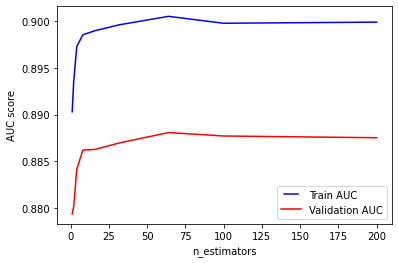

64 0.8880704914719753


In [367]:
# Define a list of hyperparameter values we want to consider 

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

# Empty lists to hold our training and validation results for the ROC AUC curves

train_results = []
val_results = []

# Loop over the range of hyperparameter values, calculate ROC AUC for both the
# training and validation data, and append them to our lists

for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   fpr, tpr, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(fpr, tpr)
   train_results.append(roc_auc)
   val_pred = rf.predict(X_val)
   fpr, tpr, thresholds = roc_curve(y_val, val_pred)
   roc_auc = auc(fpr, tpr)
   val_results.append(roc_auc)

# Plot the results 
fig = plt.figure()
line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, val_results, 'r', label='Validation AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')

fig.savefig("images/n_estimators.png")
plt.show()

# Get the optimum AUC score

max_y = max(val_results)  # Find the maximum y value
max_x = n_estimators[val_results.index(max_y)]  # Find the x value corresponding to the maximum y value
print (max_x, max_y)

We can see that our model sharply increases its AUC score and then tapers off. With that in mind, the best number of estimators for us to use in our final model is 64. Let's move on to examining max_depth.

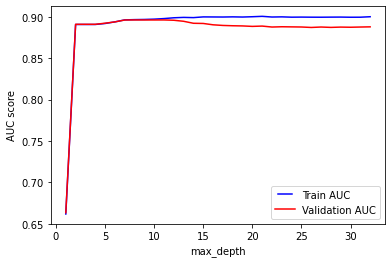

8.0 0.8963674595644765


In [368]:
# Define a list of hyperparameter values we want to consider 

max_depths = np.linspace(1, 32, 32, endpoint=True)

# Empty lists to hold our training and validation results for the ROC AUC curves

train_results = []
val_results = []

# Loop over the range of hyperparameter values, calculate ROC AUC for both the
# training and validation data, and append them to our lists

for max_depth in max_depths:
   rf = RandomForestClassifier(n_estimators = 64, max_depth=max_depth, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   fpr, tpr, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(fpr, tpr)
   train_results.append(roc_auc)
   val_pred = rf.predict(X_val)
   fpr, tpr, thresholds = roc_curve(y_val, val_pred)
   roc_auc = auc(fpr, tpr)
   val_results.append(roc_auc)
    
# Plot the results 

fig= plt.figure()
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, val_results, 'r', label='Validation AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_depth')

fig.savefig("images/max_depth.png")
plt.show()

# Get the optimum AUC score

max_y = max(val_results)  # Find the maximum y value
max_x = max_depths[val_results.index(max_y)]  # Find the x value corresponding to the maximum y value
print (max_x, max_y)

Looks like a depth of 8 gives us the best results for depth. Next up is the minimum sample split. We'll use a similar technique with this hyperparameter.

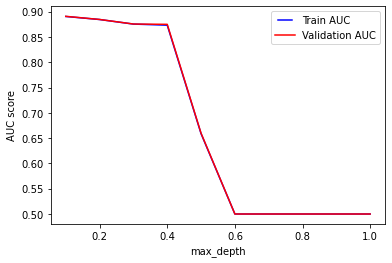

0.1 0.8908071572357847


In [369]:
# Define a list of hyperparameter values we want to consider 

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

# Empty lists to hold our training and validation results for the ROC AUC curves

train_results = []
val_results = []

# Loop over the range of hyperparameter values, calculate ROC AUC for both the
# training and validation data, and append them to our lists

for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(n_estimators = 64, max_depth=8, min_samples_split=min_samples_split, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   fpr, tpr, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(fpr, tpr)
   train_results.append(roc_auc)
   val_pred = rf.predict(X_val)
   fpr, tpr, thresholds = roc_curve(y_val, val_pred)
   roc_auc = auc(fpr, tpr)
   val_results.append(roc_auc)
    
# Plot the results 

fig= plt.figure()
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, val_results, 'r', label='Validation AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_depth')

fig.savefig("images/min_sample_splits.png")
plt.show()

# Get the optimum AUC score

max_y = max(val_results)  # Find the maximum y value
max_x = min_samples_splits[val_results.index(max_y)]  # Find the x value corresponding to the maximum y value
print (max_x, max_y)

Our optimal min_samples_split is 0.1, giving us an ROC AUC score of 0.89. Finally, let's consider our min_samples_leaf parameter.

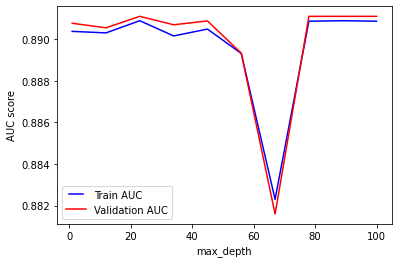

23.0 0.8911019927766612


In [370]:
# Define a list of hyperparameter values we want to consider 

min_samples_leafs = np.linspace(1,100,10, endpoint=True)

# Empty lists to hold our training and validation results for the ROC AUC curves

train_results = []
val_results = []

# Loop over the range of hyperparameter values, calculate ROC AUC for both the
# training and validation data, and append them to our lists

for min_samples_leaf in min_samples_leafs:
   rf = RandomForestClassifier(n_estimators = 64, max_depth=8,min_samples_split= 0.1,min_samples_leaf=int(min_samples_leaf), n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   fpr, tpr, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(fpr, tpr)
   train_results.append(roc_auc)
   val_pred = rf.predict(X_val)
   fpr, tpr, thresholds = roc_curve(y_val, val_pred)
   roc_auc = auc(fpr, tpr)
   val_results.append(roc_auc)
    
# Plot the results 

fig = plt.figure()
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, val_results, 'r', label='Validation AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_depth')

fig.savefig("images/min_samples_leaf.png")
plt.show()

# Get the optimum AUC score

max_y = max(val_results)  # Find the maximum y value
max_x = min_samples_leafs[val_results.index(max_y)]  # Find the x value corresponding to the maximum y value
print (max_x, max_y)

Our best min_samples_leaf value is 67. From our manual exploration, we've gotten the following optimal values:

* <b>n_estimators:</b> 64
* <b>max_depth:</b> 8
* <b>min_samples_split:</b> 0.1
* <b>min_samples_leaf:</b> 67

Let's now compare these results with a GridSearch - the advantage of a GridSearch is that it allows for permutations of different combinations of hyperparameters more easily than manual exploration. We will see whether this improves the overall performance of our model. 

In [305]:
# Outline the hyperparameter values we want to consider

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
max_depth = np.linspace(1, 32, 32, endpoint=True)
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf = [1,10,20,30,40,50,60,70,80,90,100]

# Combine into a dictionary

parameters = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

# Instantiate GridSearch

rf_gs = RandomForestClassifier(random_state=r_state)

gs_rf = GridSearchCV(rf_gs, parameters, cv = 3, verbose = 1, 
                      n_jobs = -1, scoring='roc_auc')

best_gs = gs_rf.fit(X_train, y_train)

# Get best parameters and best score

print(best_gs.best_score_)
print(best_gs.best_estimator_)

Fitting 3 folds for each of 31680 candidates, totalling 95040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

0.9333500798171329
RandomForestClassifier(max_depth=3.0, min_samples_split=0.1, n_estimators=4,
                       random_state=42)


We've gotten our ideal parameters and the ROC AUC score they lead to on the training set - it's a bit lower than what we had with the default hyperparameters, but this is likely because the cross validation on Grid Search gave us the mean of 3 cross-validations, so while our performance is a bit weaker, it suffers from less ovrefitting, and will thus be more helpful for the validation data. Let's test  the default random forest, our manually tuned random forest, and our grid search random forest on the validation data to compare performance.

In [350]:
# Define our 3 classifiers 

rf = RandomForestClassifier(random_state=r_state)
man_rf = RandomForestClassifier(n_estimators = 64, max_depth= 8, min_samples_split = 0.1, min_samples_leaf = 67, random_state=r_state)
grid_rf = RandomForestClassifier(n_estimators = 4, max_depth=3, min_samples_split=0.1,min_samples_leaf = 13,random_state=r_state)

# Fit them to the training data and get predictions

rf_prob, rf_pred = get_prob_pred(rf, X_train, y_train, X_val)
manrf_prob, manrf_pred = get_prob_pred(man_rf, X_train, y_train, X_val)
gridrf_prob, gridrf_pred = get_prob_pred(grid_rf, X_train, y_train, X_val)

# Get their ROC and recall scores for the validation set

rf_vauc = roc_auc_score(y_val, rf_prob)

rf_precision, rf_recall, threshold = precision_recall_curve(y_val, rf_prob)
rf_f1, rf_auc = f1_score(y_val, rf_pred), auc(rf_recall, rf_precision)

manrf_vauc = roc_auc_score(y_val, manrf_prob)

manrf_precision, manrf_recall, threshold = precision_recall_curve(y_val, manrf_prob)
manrf_f1, manrf_auc = f1_score(y_val, manrf_pred), auc(manrf_recall, manrf_precision)

gridrf_vauc = roc_auc_score(y_val, gridrf_prob)

gridrf_precision, gridrf_recall, threshold = precision_recall_curve(y_val, gridrf_prob)
gridrf_f1, gridrf_auc = f1_score(y_val, gridrf_pred), auc(gridrf_recall, gridrf_precision)

# Summarize scores

print('Default Hyperparameters: recall=%.3f ROC AUC=%.3f' % (rf_f1, rf_vauc))
print('Manual Hyperparameters: recall=%.3f ROC AUC=%.3f' % (manrf_f1, manrf_vauc))
print('GridSearch Hyperparameters: recall=%.3f ROC AUC=%.3f' % (gridrf_f1, gridrf_vauc))

Default Hyperparameters: recall=0.834 ROC AUC=0.935
Manual Hyperparameters: recall=0.826 ROC AUC=0.930
GridSearch Hyperparameters: recall=0.836 ROC AUC=0.933


We can see that the GridSearch gives us marginally better recall than the default parameters, and ultimately that's the priority for this investigation. With that in mind, let's recombine our test and validation data, retrain our model, and use the GridSearch version of our RF classifier to gauge performance against the test set. 

In [338]:
X_train_final = np.concatenate((X_train, X_val), axis=0)
y_train_final = np.concatenate((y_train, y_val), axis=0)

Now let's retrain our model and see its performance against the test set.

In [351]:
# Fit to the training data and get predictions

gridrf_prob, gridrf_pred = get_prob_pred(grid_rf, X_train_final, y_train_final, X_test)

# Get ROC and recall scores for the test set

gridrf_rauc = roc_auc_score(y_test, gridrf_prob)

gridrf_precision, gridrf_recall, threshold = precision_recall_curve(y_test, gridrf_prob)
gridrf_f1, gridrf_auc = f1_score(y_test, gridrf_pred), auc(gridrf_recall, gridrf_precision)

# Summarize scores

print('Final model performance: recall=%.3f ROC AUC=%.3f' % (gridrf_f1, gridrf_rauc))

Final model performance: recall=0.740 ROC AUC=0.933


Our recall score has dropped quite a bit, but we still have a pretty robust ROC AUC with this model. Let's have a look at the confusion matrix corresponding to our model.

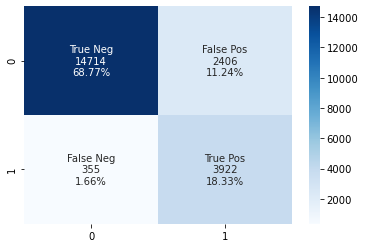

In [371]:
cmat_rf = confusion_matrix(y_test, gridrf_pred)

fig = plt.figure()
def heatmap_labels(x):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                x.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     x.flatten()/np.sum(x)]
    labels = [f"{v1}\n{v2}\n{v3}"for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    return sns.heatmap(x, annot=labels, fmt='', cmap='Blues')

heatmap_labels(cmat_rf)

fig.savefig("images/final_model_heatmap.png")
plt.show()

This is a great result for our purposes! Recall that our purpose was to identify as many true positives as possible, and we were willing to accept a higher number of false positives in exchange because the interventions we would implement to mitigate medical appointment no-shows likely wouldn't deter those who were intending to show up to appointments but received a little more 'attention' because they were falsely marked as likely to no-show. 

Given that <u> this model can identify 91% of our true positive cases</u>, it can be very useful for healthcare practitioners when targeting patients for interventions. 